# Machine Learning - Practical 4 - Deep Learning VS Trees


Names: {Sönke Hänel, Dmytro Savchuk, Phil Tobeck}  
Summer Term 2023   
Due Date: Tuesday, June 13, 2pm

In this practical we are going to use a tabular dataset. We will test two different approaches - forests and neural networks and compare performance. We are also going to learn how to make trees interpretable.

To prepare this tutorial we used [this paper](https://arxiv.org/pdf/2207.08815.pdf) with its [repository](https://github.com/LeoGrin/tabular-benchmark).

For explained variance in trees, you can read more [here](https://scikit-learn.org/0.15/auto_examples/ensemble/plot_gradient_boosting_regression.html#example-ensemble-plot-gradient-boosting-regression-py).


In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
torch.manual_seed(42) # Set manual seed

In [2]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Load, clean and split the tabular dataset

We use the preprocessing pipeline from [Grinsztajn, 2022](https://arxiv.org/pdf/2207.08815.pdf).

**No missing data**    

Remove all rows containing at least one missing entry.    

*In practice people often do not remove rows with missing values but try to fill missing values in a column with the mean or median values for numerical data and mode or median values for categorical data. Sometimes even simple prediction models are used to fill in the gaps but we will remove rows or columns with missing values for the sake of simplicity*

**Balanced classes**   

For classification, the target is binarised if there are multiple classes, by taking the two most numerous classes, and we keep half of samples in each class.

**Low cardinality categorical features**   

Remove categorical features with more than 20 items. 

**High cardinality numerical features**   

Remove numerical features with less than 10 unique values. Convert numerical features with 2 unique values to categorical.

**Data description:**  
Data reported to the police about the circumstances of personal injury road accidents in Great Britain from 1979. This version includes data up to 2015. We will try to predict the sex of the driver based on the data provided.

In [3]:
## In case you have any issues with loading the pickle file
## check that your pandas version is 1.4.1
## or just simply run:
## pip install pandas==1.4.1

with open('data/adopted_road_safety.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [4]:
dataset

,Accident_Index,Vehicle_Reference_df_res,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,...,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type,Casualty_IMD_Decile
0,201501BS70001,1,19.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,7.0,3,5.0,1.0,0.0,0.0,2.0,0,NaN,NaN
1,201501BS70002,1,9.0,0.0,9.0,0.0,8.0,0.0,0.0,0.0,...,5.0,3,9.0,9.0,0.0,0.0,2.0,0,1.0,3.0
2,201501BS70004,1,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,6.0,3,1.0,3.0,0.0,0.0,2.0,0,1.0,6.0
3,201501BS70005,1,9.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,...,2.0,3,5.0,1.0,0.0,0.0,2.0,0,1.0,2.0
4,201501BS70008,1,1.0,0.0,18.0,0.0,8.0,0.0,0.0,0.0,...,8.0,2,0.0,0.0,0.0,0.0,0.0,1,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363238,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,1.0,3,0.0,0.0,2.0,0.0,0.0,9,1.0,NaN
363239,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,5.0,3,0.0,0.0,0.0,0.0,0.0,9,1.0,2.0
363240,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,4.0,3,0.0,0.0,0.0,0.0,0.0,9,2.0,5.0
363241,2015984141415,13,9.0,0.0,18.0,0.0,0.0,0.0,0.0,5.0,...,6.0,3,0.0,0.0,0.0,0.0,0.0,9,3.0,NaN


In [5]:
target_column = 'Sex_of_Driver'
test_size = 0.2
random_state = 42

In [6]:
def remove_nans(df):
    '''
    This function removes rows with NaN values.
    '''
    # Drop rows with NaN values
    df = df.dropna()  
    return df


def numerical_to_categorical(df, n=2, ignore=[target_column]):
    '''
    Change the type of the column to categorical 
    if it has <= n unique values.
    '''
    # Initoate shallow copy of df
    df = df.copy()

    for column in df.columns:

        if column not in ignore:
            # Calculate the number of unique values in the column
            unique_values = df[column].nunique()  

            # Change column type to categorical if condition is met
            if unique_values <= n:
                df.loc[:, column] = df[column].astype('category')  
        else:
            # If the column is in the ignore list, do nothing
            pass

    return df


def remove_columns_by_n(df, n=10, condition=np.number, direction='less', ignore=[target_column]):
    '''
    Remove columns with more or less than n unique values.
    The function can be applied to either categorical or numerical columns based on the provided condition parameter.
    With the default values, it removes all numerical columns that have less than 10 unique values (except for the target_column).
    '''

    if direction not in ['less', 'more']:
        raise ValueError("Invalid direction. Choose either 'less' or 'more'.")

    if condition == 'category':
        filtered_columns = df.select_dtypes(include='category').columns

    elif condition == np.number:
        filtered_columns = df.select_dtypes(include=np.number).columns

    else:
        raise ValueError("Invalid condition. Choose either 'category' or np.number")

    for column in filtered_columns:
        if column not in ignore:
            unique_values = df[column].nunique()

            if direction == 'less' and unique_values < n:
                df.drop(column, axis=1, inplace=True)

            elif direction == 'more' and unique_values > n:
                df.drop(column, axis=1, inplace=True)

    return df

In [7]:
df = dataset

In [8]:
df = dataset

sex_counts = df['Sex_of_Driver'].value_counts()
print(sex_counts)

for column in df.columns:
    unique_values = df[column].nunique()
    print(f"Column '{column}' has {unique_values} unique values.")

# Count the occurrences of each value in the "Sex_of_Driver" column
sex_counts = df['Sex_of_Driver'].value_counts()


1.0    238639
2.0    104780
3.0     19824
Name: Sex_of_Driver, dtype: int64
Column 'Accident_Index' has 140056 unique values.
Column 'Vehicle_Reference_df_res' has 37 unique values.
Column 'Vehicle_Type' has 20 unique values.
Column 'Towing_and_Articulation' has 6 unique values.
Column 'Vehicle_Manoeuvre' has 18 unique values.
Column 'Vehicle_Location-Restricted_Lane' has 10 unique values.
Column 'Junction_Location' has 9 unique values.
Column 'Skidding_and_Overturning' has 6 unique values.
Column 'Hit_Object_in_Carriageway' has 12 unique values.
Column 'Vehicle_Leaving_Carriageway' has 9 unique values.
Column 'Hit_Object_off_Carriageway' has 12 unique values.
Column '1st_Point_of_Impact' has 5 unique values.
Column 'Was_Vehicle_Left_Hand_Drive?' has 2 unique values.
Column 'Journey_Purpose_of_Driver' has 6 unique values.
Column 'Sex_of_Driver' has 3 unique values.
Column 'Age_of_Driver' has 95 unique values.
Column 'Age_Band_of_Driver' has 11 unique values.
Column 'Engine_Capacity_(CC

In [9]:
## Balanced classes   

# For classification, the target is binarised if there are multiple classes, by taking the two most numerous classes, and we keep half of samples in each class.

In [10]:
# Get the two most common values
top_two_values = sex_counts.index[:2]

# Filter the DataFrame based on the condition
df_filtered = df[df['Sex_of_Driver'].isin(top_two_values)]

# Group the filtered DataFrame by the 'Sex_of_Driver' column
grouped = df_filtered.groupby('Sex_of_Driver')

# Create an empty DataFrame to store the balanced data
balanced_df = pd.DataFrame()

# Iterate over each group
for group_name, group_data in grouped:
    # Calculate the number of samples in the group
    group_count = len(group_data)

    # Calculate the number of samples to keep from the group (half of the total)
    samples_to_keep = group_count // 2

    # Randomly select the samples to keep from the group
    sampled_data = group_data.sample(n=samples_to_keep, random_state=42)

    # Append the sampled data to the balanced DataFrame
    balanced_df = balanced_df.append(sampled_data)

# Update the original DataFrame with the balanced data
df = balanced_df.copy()
    
sex_counts = df['Sex_of_Driver'].value_counts()
print(sex_counts)

for column in df.columns:
    unique_values = df[column].nunique()
    print(f"Column '{column}' has {unique_values} unique values.")

C:\Users\Soenke\AppData\Local\Temp\ipykernel_23752\1962303223.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = balanced_df.append(sampled_data)
C:\Users\Soenke\AppData\Local\Temp\ipykernel_23752\1962303223.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = balanced_df.append(sampled_data)
C:\Users\Soenke\AppData\Local\Temp\ipykernel_23752\1962303223.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = balanced_df.append(sampled_data)


1.0    119319
2.0     52390
3.0         0
Name: Sex_of_Driver, dtype: int64
Column 'Accident_Index' has 98105 unique values.
Column 'Vehicle_Reference_df_res' has 37 unique values.
Column 'Vehicle_Type' has 20 unique values.
Column 'Towing_and_Articulation' has 6 unique values.
Column 'Vehicle_Manoeuvre' has 18 unique values.
Column 'Vehicle_Location-Restricted_Lane' has 10 unique values.
Column 'Junction_Location' has 9 unique values.
Column 'Skidding_and_Overturning' has 6 unique values.
Column 'Hit_Object_in_Carriageway' has 12 unique values.
Column 'Vehicle_Leaving_Carriageway' has 9 unique values.
Column 'Hit_Object_off_Carriageway' has 12 unique values.
Column '1st_Point_of_Impact' has 5 unique values.
Column 'Was_Vehicle_Left_Hand_Drive?' has 2 unique values.
Column 'Journey_Purpose_of_Driver' has 6 unique values.
Column 'Sex_of_Driver' has 2 unique values.
Column 'Age_of_Driver' has 94 unique values.
Column 'Age_Band_of_Driver' has 11 unique values.
Column 'Engine_Capacity_(CC)

In [11]:
df = remove_nans(df)
df = numerical_to_categorical(df, n=2, ignore=[target_column])
df = remove_columns_by_n(df, n=10, condition=np.number, direction='less', 
                         ignore=[target_column])
df = remove_columns_by_n(df, n=40, condition='category', direction='more', 
                         ignore=[target_column])
assert not df.isna().any().any(), 'There are still nans in the dataframe'

In [12]:
# TODO : make train-test split from the dataframe using the parameters above
# expected results variable names - train_X, test_X, train_y, test_y

X = df.drop(target_column, axis=1)
Y = df[target_column]

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=test_size, random_state=random_state)

print("Original dataset dimensions: ", dataset.shape)
print("Preprocessed dataset dimensions: ", df.shape)

Original dataset dimensions:  (363243, 67)
Preprocessed dataset dimensions:  (47765, 29)


In [13]:
for column in df.columns:
    unique_values = df[column].nunique()
    print(f"Column '{column}' has {unique_values} unique values.")

sex_counts = df['Sex_of_Driver'].value_counts()
print(sex_counts)

# Count the occurrences of each value in the "Sex_of_Driver" column
sex_counts = df['Sex_of_Driver'].value_counts()

# Get the two most common values
top_two_values = sex_counts.index[:2]

# Filter the DataFrame based on the condition
df_filtered = df[df['Sex_of_Driver'].isin(top_two_values)]

# Update the original DataFrame with the filtered data
df = df_filtered.copy()

# Print the updated DataFrame
print(df)

Column 'Vehicle_Type' has 15 unique values.
Column 'Vehicle_Manoeuvre' has 18 unique values.
Column 'Vehicle_Location-Restricted_Lane' has 10 unique values.
Column 'Hit_Object_in_Carriageway' has 12 unique values.
Column 'Hit_Object_off_Carriageway' has 12 unique values.
Column 'Was_Vehicle_Left_Hand_Drive?' has 2 unique values.
Column 'Sex_of_Driver' has 2 unique values.
Column 'Age_of_Driver' has 83 unique values.
Column 'Age_Band_of_Driver' has 10 unique values.
Column 'Engine_Capacity_(CC)' has 761 unique values.
Column 'Age_of_Vehicle' has 56 unique values.
Column 'Location_Easting_OSGR' has 24086 unique values.
Column 'Location_Northing_OSGR' has 24245 unique values.
Column 'Longitude' has 30293 unique values.
Column 'Latitude' has 30177 unique values.
Column 'Police_Force' has 37 unique values.
Column 'Number_of_Casualties' has 15 unique values.
Column 'Local_Authority_(District)' has 302 unique values.
Column '1st_Road_Number' has 2436 unique values.
Column '2nd_Road_Number' ha

**TODO :**  

* Did you split the dataset in a stratified manner or not? Why?
We didnt split it in a stratified manner as we only filtered out rows and columns. It would be a stratified manner if we attributed to every data in the same region the same value. We don't do that here.
* How did the dataset dimensions change after preprocessing?
Original dataset dimensions:  (363243, 67)
Preprocessed dataset dimensions:  (96326, 29), but if we delete the rarest sex from the dataset: [96173 rows x 29 columns]
If we "only take every second sample from the 2 most common classes" we have: [47765 rows x 29 columns]
* How many unique values are in the response variable?
The responst variable had 3 unique values but (as is stated in the task description we filter out the classes that are not 2 most common so now it has 2.

## Task 1: Create a GradientBoostingClassifier

In [14]:
## TODO : define the GradientBoostingClassifier, 

## train it on the train set and predict on the test set

# Define GradientBoostingClassifier
model = GradientBoostingClassifier()

# Train model
model.fit(train_X, train_y)

# Predict on test set
predictions = model.predict(test_X)


In [15]:
## TODO : print  accuracy, precision, recall
## Hint : use functions from sklearn metrics

# Compute accuracy
accuracy = accuracy_score(test_y, predictions)
print("Accuracy:", accuracy)

# Compute precision
precision = precision_score(test_y, predictions, average='weighted')
print("Precision:", precision)

# Compute recall
recall = recall_score(test_y, predictions, average='weighted')
print("Recall:", recall)

Accuracy: 0.761122160577829
Precision: 0.7544281499804729
Recall: 0.761122160577829


In [16]:
## TODO : Write a function which iterates over trees_amount, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def trees_amount_exploration(train_X, train_y, test_X, test_y, trees_amount=[1, 20, 50, 100]):
    #TODO
    for n_trees in trees_amount:
        # Define GradientBoostingClassifier with the specified number of trees
        model = GradientBoostingClassifier(n_estimators=n_trees)

        # Train model
        model.fit(train_X, train_y)

        # Predict on test set
        predictions = model.predict(test_X)

        # Compute accuracy
        accuracy = accuracy_score(test_y, predictions)

        # Compute precision
        precision = precision_score(test_y, predictions, average='weighted', zero_division=0)

        # Compute recall
        recall = recall_score(test_y, predictions, average='weighted')

        # Print the metrics
        print(f"Number of Trees: {n_trees}")
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("--------------------")




In [17]:
#trees_amount_exploration(train_X, train_y, test_X, test_y, trees_amount=[1000])
trees_amount_exploration(train_X, train_y, test_X, test_y)

Number of Trees: 1
Accuracy: 0.6580131895739558
Precision: 0.43298135765329077
Recall: 0.6580131895739558
--------------------
Number of Trees: 20
Accuracy: 0.7450015701873757
Precision: 0.7363465855532726
Recall: 0.7450015701873757
--------------------
Number of Trees: 50
Accuracy: 0.7551554485501937
Precision: 0.7475914291204476
Recall: 0.7551554485501937
--------------------
Number of Trees: 100
Accuracy: 0.761122160577829
Precision: 0.7544281499804729
Recall: 0.761122160577829
--------------------


In [18]:
## TODO : Write a function which iterates over the learning rate, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def learning_rate_exploration(train_X, train_y, test_X, test_y, learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5], trees_amount=100):
    #TODO
    for lr in learning_rates:
        # Define GradientBoostingClassifier with specified learning rate and amount of trees
        model = GradientBoostingClassifier(learning_rate=lr, n_estimators=trees_amount)

        # Train model
        model.fit(train_X, train_y)

        # Predict on test set
        predictions = model.predict(test_X)

        # Compute accuracy
        accuracy = accuracy_score(test_y, predictions)

        # Compute precision
        precision = precision_score(test_y, predictions, average='weighted', zero_division=0)

        # Compute recall
        recall = recall_score(test_y, predictions, average='weighted')

        # Print the metrics
        print(f"Learning Rate: {lr}")
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("--------------------")


In [19]:
learning_rate_exploration(train_X, train_y, test_X, test_y)

Learning Rate: 0.1
Accuracy: 0.761122160577829
Precision: 0.7544281499804729
Recall: 0.761122160577829
--------------------
Learning Rate: 0.2
Accuracy: 0.7688684182979169
Precision: 0.7635606575969445
Recall: 0.7688684182979169
--------------------
Learning Rate: 0.3
Accuracy: 0.7734743012666179
Precision: 0.7684111848845164
Recall: 0.7734743012666179
--------------------
Learning Rate: 0.4
Accuracy: 0.7752538469590704
Precision: 0.7707062403923071
Recall: 0.7752538469590704
--------------------
Learning Rate: 0.5
Accuracy: 0.774416413692034
Precision: 0.769775128361752
Recall: 0.774416413692034
--------------------


In [20]:
## TODO : Write a function which iterates over different depths, 
## train a classifier with a specified depth and print accuracy, precision, and recall
## Set trees_amount= 50 to make the calculations faster
## Note: the calculations may take several minutes (depending on the computer efficiency).

def max_depth_exploration(train_X, train_y, test_X, test_y, depths=[1,2,3,5]):
    # TODO
    trees_amount = 50

    for depth in depths:
        # Define GradientBoostingClassifier with the specified depth and number of trees
        model = GradientBoostingClassifier(max_depth=depth, n_estimators=trees_amount)

        # Train model
        model.fit(train_X, train_y)

        # Predict on test set
        predictions = model.predict(test_X)

        # Compute accuracy
        accuracy = accuracy_score(test_y, predictions)

        # Compute precision
        precision = precision_score(test_y, predictions, average='weighted', zero_division=0)

        # Compute recall
        recall = recall_score(test_y, predictions, average='weighted')

        # Print the metrics
        print(f"Max Depth: {depth}")
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("--------------------")


In [21]:
max_depth_exploration(train_X, train_y, test_X, test_y)

Max Depth: 1
Accuracy: 0.7409190830105726
Precision: 0.731819764793888
Recall: 0.7409190830105726
--------------------
Max Depth: 2
Accuracy: 0.7411284413273317
Precision: 0.732035280174608
Recall: 0.7411284413273317
--------------------
Max Depth: 3
Accuracy: 0.7551554485501937
Precision: 0.7475914291204476
Recall: 0.7551554485501937
--------------------
Max Depth: 5
Accuracy: 0.7730555846330995
Precision: 0.7678209421009126
Recall: 0.7730555846330995
--------------------


**TODO :**   

* How does the max_depth parameter influence the results?

-> Accuracy: increases
-> Precision: ''
-> Recall: ''

* How does the learning rate influence the results?

-> Accuracy: increases, then falls (for lr = 0.4 Accuracy bigger than for lr = 0.5)
-> Precision: ''
-> Recall: ''

* How does the number of trees in the ensemble influence the results?

-> Accuracy: increases (or at least stays the same) 
-> Precision: ''
-> Recall: ''

* Try to improve the accuracy by combining different max_depth, learning rate and number of trees. How well does your best model perform?

In [22]:
### DELETE LATER IF GARBAGE
def parameter_exploration(train_X, train_y, test_X, test_y, depths=[1, 2, 3, 5], learning_rates=[0.1, 0.2, 0.3, 0.4, 0.5], trees_amount=[1, 20, 50, 100]):
    for depth in depths:
        for lr in learning_rates:
            for n_trees in trees_amount:
                # Define GradientBoostingClassifier with the specified depth, learning rate, and number of trees
                model = GradientBoostingClassifier(max_depth=depth, learning_rate=lr, n_estimators=n_trees)

                # Train model
                model.fit(train_X, train_y)

                # Predict on test set
                predictions = model.predict(test_X)

                # Compute accuracy
                accuracy = accuracy_score(test_y, predictions)

                # Compute precision
                precision = precision_score(test_y, predictions, average='weighted', zero_division=0)

                # Compute recall
                recall = recall_score(test_y, predictions, average='weighted')

                # Print the metrics
                print(f"Max Depth: {depth}, Learning Rate: {lr}, Number of Trees: {n_trees}")
                print("Accuracy:", accuracy)
                print("Precision:", precision)
                print("Recall:", recall)
                print("--------------------")
parameter_exploration(train_X, train_y, test_X, test_y)

Max Depth: 1, Learning Rate: 0.1, Number of Trees: 1
Accuracy: 0.6580131895739558
Precision: 0.43298135765329077
Recall: 0.6580131895739558
--------------------
Max Depth: 1, Learning Rate: 0.1, Number of Trees: 20
Accuracy: 0.7409190830105726
Precision: 0.731819764793888
Recall: 0.7409190830105726
--------------------
Max Depth: 1, Learning Rate: 0.1, Number of Trees: 50
Accuracy: 0.7409190830105726
Precision: 0.731819764793888
Recall: 0.7409190830105726
--------------------
Max Depth: 1, Learning Rate: 0.1, Number of Trees: 100
Accuracy: 0.7414424788024704
Precision: 0.7322910514908738
Recall: 0.7414424788024704
--------------------
Max Depth: 1, Learning Rate: 0.2, Number of Trees: 1
Accuracy: 0.6580131895739558
Precision: 0.43298135765329077
Recall: 0.6580131895739558
--------------------
Max Depth: 1, Learning Rate: 0.2, Number of Trees: 20
Accuracy: 0.7409190830105726
Precision: 0.731819764793888
Recall: 0.7409190830105726
--------------------
Max Depth: 1, Learning Rate: 0.2, Nu

Max Depth: 3, Learning Rate: 0.3, Number of Trees: 100
Accuracy: 0.7735789804249974
Precision: 0.7685138390423046
Recall: 0.7735789804249974
--------------------
Max Depth: 3, Learning Rate: 0.4, Number of Trees: 1
Accuracy: 0.7253218884120172
Precision: 0.7196763278249949
Recall: 0.7253218884120172
--------------------
Max Depth: 3, Learning Rate: 0.4, Number of Trees: 20
Accuracy: 0.7577724275096829
Precision: 0.7509079023567959
Recall: 0.7577724275096829
--------------------
Max Depth: 3, Learning Rate: 0.4, Number of Trees: 50
Accuracy: 0.772218151366063
Precision: 0.767270523696384
Recall: 0.772218151366063
--------------------
Max Depth: 3, Learning Rate: 0.4, Number of Trees: 100
Accuracy: 0.77535852611745
Precision: 0.7708226250249881
Recall: 0.77535852611745
--------------------
Max Depth: 3, Learning Rate: 0.5, Number of Trees: 1
Accuracy: 0.7253218884120172
Precision: 0.7196763278249949
Recall: 0.7253218884120172
--------------------
Max Depth: 3, Learning Rate: 0.5, Number 

In [23]:
## TODO -  sklearn trees have the attribute feature_importances_
## make a plot, to show relative importance (maximum is 1) of your classifier and
## order features from most relevant feature to the least relevant in the plot
## What we want to plot here is the importance of features in Gradient Boosting Classifier, not explained variance of Gradient Boosting Classifier based on explained_variance_ratio

def plot_explained_variance(clf, X):
    # Get feature importances from the classifier
    importances = clf.feature_importances_

    # Get feature names from the feature matrix
    feature_names = X.columns

    # Sort feature importances in descending order
    sorted_indices = importances.argsort()[::-1]
    sorted_importances = importances[sorted_indices]
    sorted_feature_names = feature_names[sorted_indices]

    # Create a bar plot to show relative feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sorted_importances, y=sorted_feature_names, palette='muted')
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()



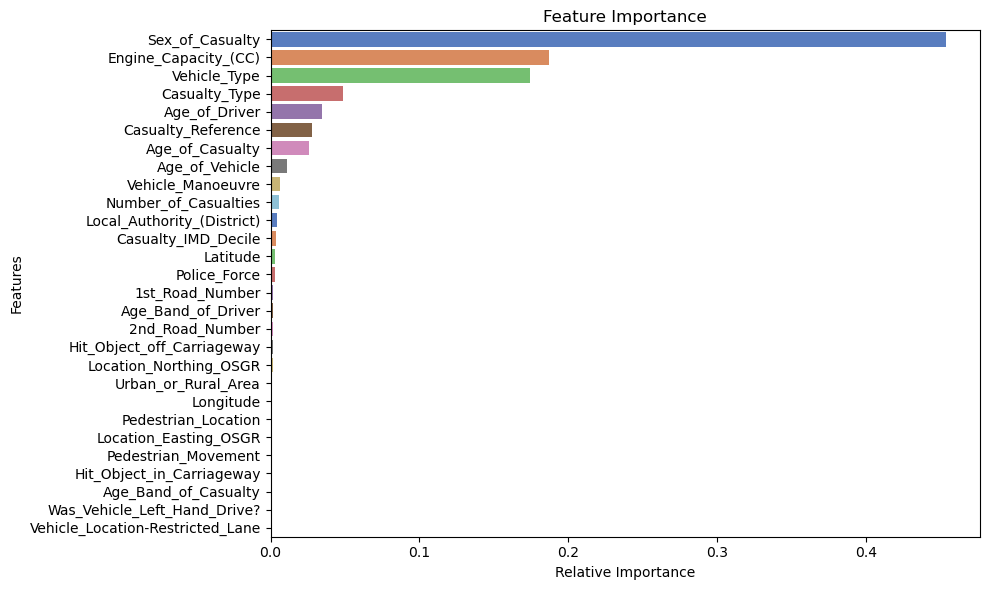

In [24]:
## TODO : display the plot
plot_explained_variance(model, X)



**TODO :** Some features are really not important, while few are very important (Sex of casualty, CC, vehicle type)...

**TODO (optional):** Try to remove the least-important features and see what happens. Does to quality improve or degrade? Why? 

## Prepare for deep learning
### Add all the necessary training functions 
*You can reuse them from previous practical exercises*

In [25]:
## TODO write a function that calculates the accuracy
## Hint - you can use yours from practical 3 

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    return correct/total

In [26]:
## TODO : Define a train and validation functions here
## Hint - you can use yours from practical 3 

def train(dataloader, optimizer, model, loss_fn, device):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_samples = 0

    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        train_loss += loss.item() * inputs.size(0)

        _, predicted_labels = torch.max(outputs, 1)
        train_correct += (predicted_labels == targets).sum().item()
        total_samples += targets.size(0)

        loss.backward()
        optimizer.step()

    train_loss /= total_samples
    train_acc = train_correct / total_samples

    return train_loss, train_acc

def validate(dataloader, model, loss_fn, device):
    val_losses = []
    correct_predictions = 0
    total_samples = 0

    model.eval()

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device).squeeze()

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            val_losses.append(loss.item())

            _, predicted_labels = torch.max(outputs, 1)
            correct_predictions += (predicted_labels == targets).sum().item()
            total_samples += targets.size(0)

    mean_loss = sum(val_losses) / len(val_losses)
    accuracy = correct_predictions / total_samples

    return mean_loss, accuracy

In [27]:
#TODO write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from practical 3 
from tqdm import trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    model.to(device)
    loss_function.to(device)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in trange(num_epochs, desc='Epoch'):
        train_loss, train_acc = train(train_dataloader, optimizer, model, loss_function, device)
        val_loss, val_acc = validate(val_dataloader, model, loss_function, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    return train_losses, val_losses, train_accs, val_accs

    """ method to run the training procedure """
    # TODO: write a run_training function that 
  # - calls the train and validate functions for each epoch
  # - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch

In [28]:
# TODO write a plot function 
## Hint - you can use yours from practical 2 or 3 
## TODO: Plot both train and val losses for all models. 
## What do you see?

def plot(title, ylabel, train_data, val_data):
    # Create an array of epoch numbers for the x-axis
    epochs = range(1, len(train_data) + 1)

    # Plot the training data
    plt.plot(epochs, train_data, label='Training')

    # Plot the validation data
    plt.plot(epochs, val_data, label='Validation')

    # Set the x-axis label
    plt.xlabel('Epoch')

    # Set the y-axis label
    plt.ylabel(ylabel)

    # Set the title of the plot
    plt.title(title)

    # Display a legend
    plt.legend()

    # Show the plot
    plt.show()

### Convert a pandas dataframe to a PyTorch dataset

In [29]:
import torch
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import trange

class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, df_x, df_y, mean=None, std=None, normalise=True):
        self.x = df_x.to_numpy()

        self.label_encoder = LabelEncoder()
        self.y = self.label_encoder.fit_transform(df_y)

        self.mean = mean
        self.std = std
        self.normalise = normalise

        if self.normalise:
            self.mean = self.x.mean(axis=0)
            self.std = self.x.std(axis=0)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]

        if self.normalise:
            x = (x - self.mean) / self.std

        return x, torch.LongTensor([y])


In [30]:
# Calculate mean and std for the train set
# Define new datasets with mean, std, and normalise=True
train_dataset = TabularDataset(train_X, train_y, normalise=False)
train_mean = train_dataset.x.mean(axis=0)
train_std = train_dataset.x.std(axis=0)

val_size = 0.1
# Split the training set further into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=val_size, random_state=random_state)

response_dtype = train_dataset.label_encoder.transform(train_y.to_numpy()).dtype

In [31]:
# TODO : define new datasets with mean, std and normalise=True
# be careful with the labels, they should start from 0!




train_dataset = TabularDataset(train_X, train_y, mean=train_mean, std=train_std, normalise=True)
val_dataset = TabularDataset(val_X, val_y, mean=train_mean, std=train_std, normalise=True)
test_dataset = TabularDataset(test_X, test_y, mean=train_mean, std=train_std, normalise=True)

# Define dataloaders with specified batch size and shuffled
batch_size = 256
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




## Logistic regression

In [32]:
class LR(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LR, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = x.to(self.linear.weight.dtype)  # Convert input tensor to the same data type as the weight tensor
        outputs = self.linear(x)
        return outputs



In [33]:
## TODO define model, loss and optimisers
## don't forget to move everything for the correct devices
## 
lr = 0.001
input_dim = train_X.shape[1]
output_dim = len(train_dataset.label_encoder.classes_)

model = LR(input_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [34]:
## TODO train the network
num_epochs = 30
train_losses_lr, val_losses_lr, train_accs_lr, val_accs_lr = run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader)


Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 30/30 [00:16<00:00,  1.80it/s]


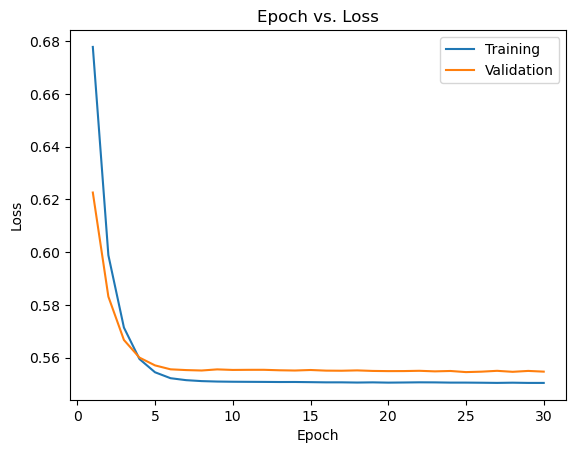

In [35]:
## todo - plot losses and accuracies
plot('Epoch vs. Loss', 'Loss', train_losses_lr, val_losses_lr)
## todo - plot losses and accuracies
#plot(train_losses_lr, val_losses_lr)

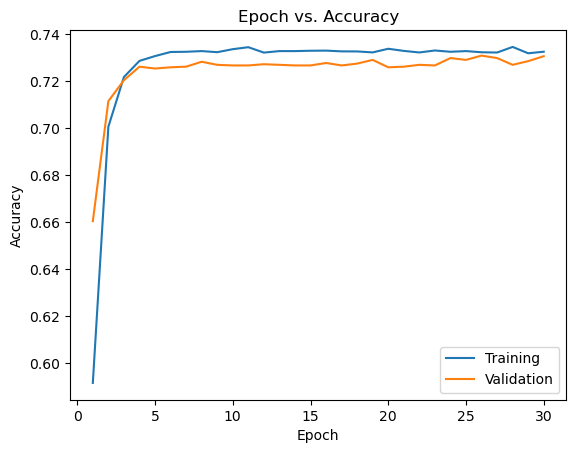

In [36]:
plot('Epoch vs. Accuracy', 'Accuracy', train_accs_lr, val_accs_lr)
#plot(train_accs_lr, val_accs_lr)


## Create a simple MLP

As the default tree has 3 layers, let's make a MLP with 3 linear layers and ReLU.
Please notice that making convolutions on tabular data does not make much sense even though it is technically possible.   

**TODO :** Explain why making convolutions on tabular data does not make much sense. Why do we use an MLP, not a CNN from the previous homework?

 CNN exploits spatial relationships present in the data, which we shouldn't have in tabular data, especially if X gets shuffled.. Hence if we want to use a neural network to estimate non-lineare relationship we cant use a CNN but a MLP.
 

In [37]:
class TabularNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(TabularNetwork, self).__init__()
        self.network = nn.Sequential(
            # TODO : define 3 linear layer with sizes 
            # input_dim -> input_dim // 2 -> output_dim
            # using ReLU as nonlinearity
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, output_dim)
        )
   
    def forward(self, x):
        """ Defines the computation performed at every call. """
        x = x.to(self.network[0].weight.dtype)  # Cast input tensor to the same data type as the weights
        return self.network(x)


In [38]:
## TODO : define model, optimiser, cross entropy loss,
## put le model to the device, and train mode
## you can optionally apply regularisation between 0.0005 and 0.005 
lr=0.001

model = TabularNetwork(input_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = torch.nn.CrossEntropyLoss()
model.to(device)
model.train()


TabularNetwork(
  (network): Sequential(
    (0): Linear(in_features=28, out_features=14, bias=True)
    (1): ReLU()
    (2): Linear(in_features=14, out_features=2, bias=True)
  )
)

In [39]:
## TODO : Train model
num_epochs = 50

train_losses, val_losses, train_accs, val_accs = run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader)

Epoch: 100%|███████████████████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.68it/s]


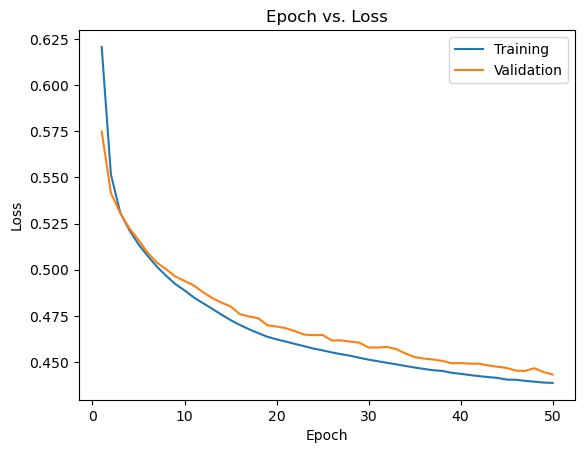

In [40]:
# TODO plot losses
plot('Epoch vs. Loss', 'Loss', train_losses, val_losses)

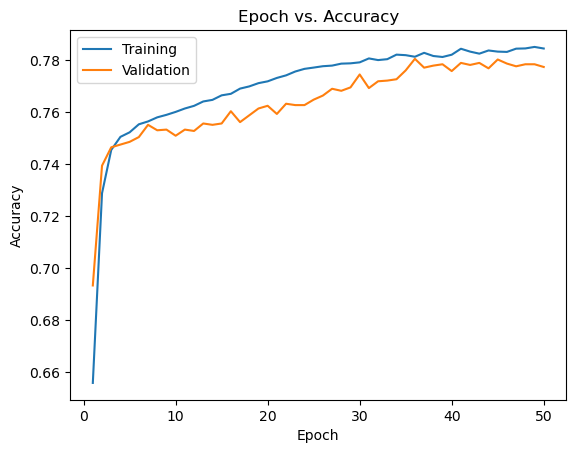

In [41]:
# TODO plot accuracies
plot('Epoch vs. Accuracy', 'Accuracy', train_accs, val_accs)

**TODO:** Did your network perform better or worse than the GradientBoostingClassifier on this dataset? Why? 
The MLP did perform better than the GradientBoostingClassifier. This may be due to the networks ability to capture non-linear relationships.


## Bonus tasks (optional)
* Try to use SGD instead of Adam as optimiser. What do you notice?
Here are different opinions on this topic:
  * https://codeahoy.com/questions/ds-interview/33/#:~:text=Adam%20tends%20to%20converge%20faster,converges%20to%20more%20optimal%20solutions.
  * https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/ 
  * https://datascience.stackexchange.com/questions/30344/why-not-always-use-the-adam-optimization-technique

* Try to make your MLP twice deeper. What do you notice? Why?

## Advanced topic to read about:
**Tools which may be helpful for data exploration:**
* df.describe() - returns some basic statistics for your dataset - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
* ydata-profiling (previous pandas-profiling) - generates interactive data exploration report: basic statistics, nans, correlations between different features - https://github.com/ydataai/ydata-profiling

**Tree libraries**
* XGBoost - XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. https://xgboost.readthedocs.io/en/stable/tutorials/model.html
* LightGBM - industrial library for XGBoost from Miscrosoft. LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient. https://lightgbm.readthedocs.io/en/v3.3.2/